In [3]:
%pip install xgboost scikit-learn pandas matplotlib seaborn shap numpy 

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import brier_score_loss, classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import shap

c:\Users\LENOVO\Downloads\diabetic_data.csv\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Step 2: Load Dataset
#df = pd.read_csv('diabetic_data.csv')
data = pd.read_csv("diabetic_data.csv")
data.replace('?', np.nan, inplace=True)

data.shape
data.head()




,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
# 2. Preprocessing
le = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = le.fit_transform(data[col].astype(str))


In [7]:
# 3. Handle missing values using KNN imputer
imputer = KNNImputer(n_neighbors=3)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

In [8]:
data.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [9]:
# 4. Feature/target split
X = data_imputed.drop('readmitted', axis=1)
# Convert 'readmitted' to binary: 0 for 'NO' or '>30', 1 for '<30'
y = data_imputed['readmitted'].apply(lambda x: 1 if x == 1 else 0)

In [10]:

# 5. Train-test split (time-aware if 'encounter_id' or 'admission_date' exists)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [11]:
# 6. Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression


models = {
    "RandomForest": RandomForestClassifier(n_estimators=150, random_state=0, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(n_estimators=150, use_label_encoder=False, eval_metric='logloss', random_state=0),
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
}



RandomForest Model
Brier Score: 0.2674
              precision    recall  f1-score   support

           0       0.87      0.13      0.23     14464
           1       0.31      0.95      0.47      5890

    accuracy                           0.37     20354
   macro avg       0.59      0.54      0.35     20354
weighted avg       0.70      0.37      0.30     20354



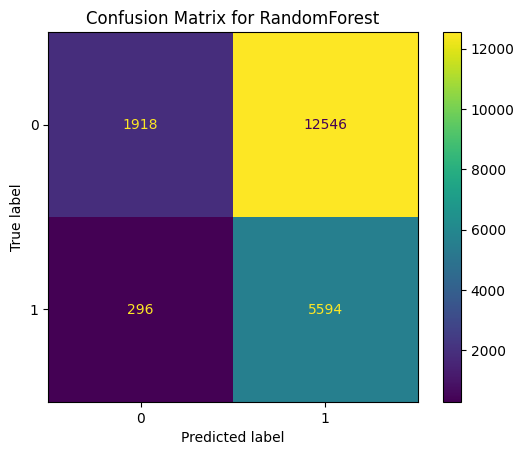

c:\Users\LENOVO\Downloads\diabetic_data.csv\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\Downloads\diabetic_data.csv\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\Downloads\diabetic_data.csv\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Model
Brier Score: 0.3205
              precision    recall  f1-score   support

           0       0.96      0.01      0.03     14464
           1       0.29      1.00      0.45      5890

    accuracy                           0.30     20354
   macro avg       0.62      0.51      0.24     20354
weighted avg       0.76      0.30      0.15     20354



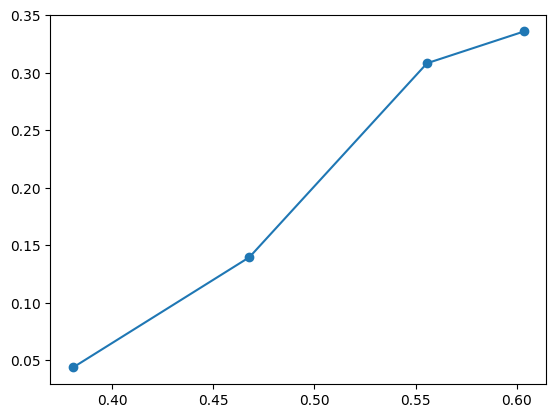

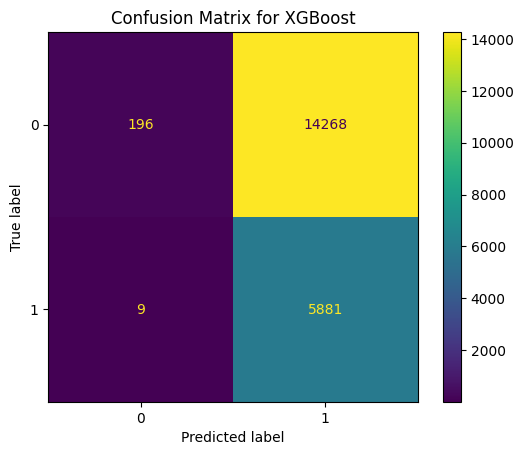


LogisticRegression Model
Brier Score: 0.2143
              precision    recall  f1-score   support

           0       0.72      0.93      0.81     14464
           1       0.42      0.13      0.19      5890

    accuracy                           0.70     20354
   macro avg       0.57      0.53      0.50     20354
weighted avg       0.63      0.70      0.63     20354



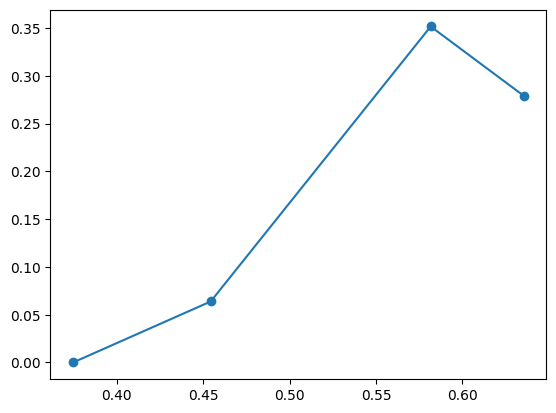

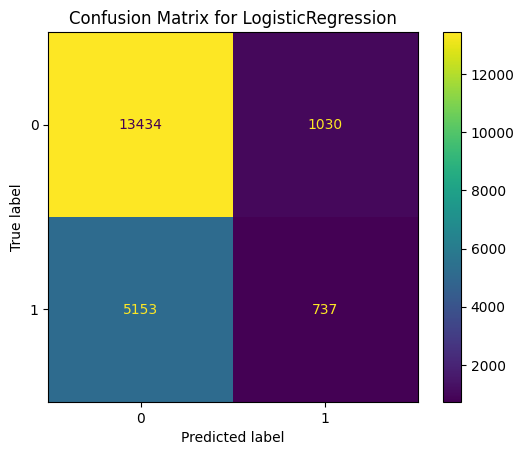

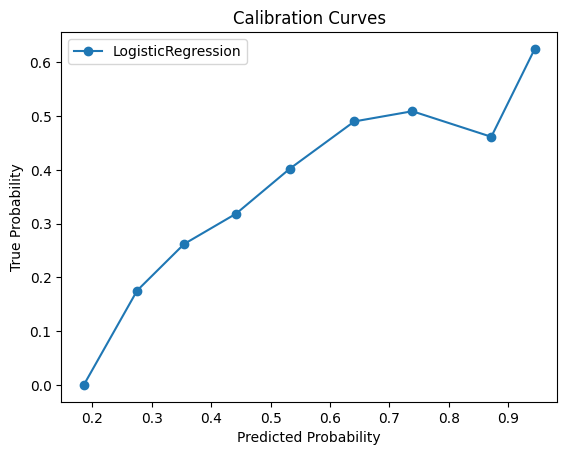

In [13]:
# 8. Training, Calibration & Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for name, model in models.items():

    calibrated = CalibratedClassifierCV(model, cv=3)
    calibrated.fit(X_train, y_train)
    y_prob = calibrated.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_prob)
    y_pred = calibrated.predict(X_test)

    print(f"\n{name} Model")
    print("Brier Score:", round(brier, 4))
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix for {name}")
    plt.show()


    # Calibration Plot
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.title("Calibration Curves")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.legend()
plt.show()

In [ ]:
# 9. Feature Importance (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=data.columns[:-1]).sort_values(ascending=False)
print("\nTop 10 Important Features:\n", importances.head(10))



Top 10 Important Features:
 patient_nbr                 0.102933
encounter_id                0.092517
num_lab_procedures          0.070451
diag_1                      0.069026
diag_2                      0.067143
diag_3                      0.065538
num_medications             0.062706
time_in_hospital            0.045809
age                         0.037570
discharge_disposition_id    0.033858
dtype: float64


: 

In [ ]:
explainer = shap.Explainer(rf, X_test, algorithm="auto")
shap_values = explainer(X_test[:300])  # only first 300 samples
shap.plots.bar(shap_values)